# 使用Sequence to Sequence 模型，英翻中
### 程式修改自 [Neural machine translation with attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention)

In [2]:
# 載入相關套件
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

## 資料前置處理函數

In [3]:
# 將 unicode 轉為 ascii 內碼的函數
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                                 if unicodedata.category(c) != 'Mn')

# 去除特殊符號的函數
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()

    # 前後加特殊字串，讓模型知道語句的開頭與結尾
    w = '<start> ' + w + ' <end>'
    return w

In [40]:
# 測試
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


## 讀取訓練資料檔

In [44]:
# 讀取訓練資料檔，轉成對照表
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in line.split('\t')[0:2]]
                for line in lines[:num_examples]]

    return zip(*word_pairs)

# 讀取訓練資料檔
path_to_file='./RNN/spa.txt'
en, sp = create_dataset(path_to_file, None)

# 顯示最後一句對照
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


## 分詞、建立 dataset

In [16]:
# 分詞
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    # 文字轉索引值
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # 長度不足補 0
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')

    return tensor, lang_tokenizer

# 建立 dataset
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# 限制 30000 筆訓練資料
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file,
                                                                num_examples)

# 計算語句最大長度
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [42]:
# 資料切割
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = \
    train_test_split(input_tensor, target_tensor, test_size=0.2)

len(input_tensor_train), len(input_tensor_val)

(24000, 6000)

In [19]:
# 索引值轉換字詞
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print(f'{t} ----> {lang.index_word[t]}')

print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
30 ----> tu
64 ----> nos
18 ----> lo
3296 ----> ensenaste
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> you
931 ----> taught
81 ----> us
19 ----> that
3 ----> .
2 ----> <end>


## 參數設定

In [ ]:
# 參數設定
BUFFER_SIZE = len(input_tensor_train) # Dataset的緩衝區大小
BATCH_SIZE = 64                       # 批量
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE # 每週期包含的步驟數
embedding_dim = 256                   # 嵌入層的輸出維度
units = 1024                          # GRU 輸出維度
vocab_inp_size = len(inp_lang.word_index)+1  # 原始語言的字彙表大小
vocab_tar_size = len(targ_lang.word_index)+1 # 目標語言的字彙表大小

## 建立 dataset

In [20]:
# 建立 dataset
dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
# 測試
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 19]), TensorShape([64, 11]))

## Encoder/decoder 及注意力(Attention)機制說明

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [45]:
# 建立模型編碼器
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                         return_sequences=True, return_state=True,
                         recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 測試
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('編碼器輸出維度: (批量, 語句長度, 輸出) =', sample_output.shape)
print('編碼器隱藏層輸出維度: (批量, 輸出) =', sample_hidden.shape)

編碼器輸出維度: (批量, 語句長度, 輸出)= (64, 19, 1024)
編碼器隱藏層輸出維度: (批量, 輸出)= (64, 1024)


In [46]:
# 建立模型注意力(Attention)機制：Bahdanau 作法
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 依虛擬程式碼的公式計算
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
                self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, 
                                                      sample_output)

print("Attention維度: (批量, 輸出) =", attention_result.shape)
print("Attention權重: (批量, 語句長度, 1) =", attention_weights.shape)

Attention維度: (批量, 輸出)= (64, 1024)
Attention權重: (批量, 語句長度, 1)= (64, 19, 1)


In [47]:
# 建立模型解碼器
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                     return_sequences=True, return_state=True,
                     recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('解碼器維度: (批量, 字彙表尺寸) =', sample_decoder_output.shape)

解碼器維度: (批量, 字彙表尺寸)= (64, 4807)


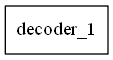

In [50]:
tf.keras.utils.plot_model(decoder)

## 指定優化器、損失函數

In [28]:
# 指定優化器、損失函數
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 損失函數
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 檢查點存檔

In [29]:
# 檢查點存檔
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                         encoder=encoder, decoder=decoder)

## 模型訓練

In [30]:
# 梯度下降函數
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    # 梯度下降
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing：以解碼器目標(y)為下一節點的輸入
        for t in range(1, targ.shape[1]):
            # 解碼器有三個輸入：目標語言的輸入、解碼器隱藏層的輸出、編碼器的輸出
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    # 梯度計算
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [31]:
# 模型訓練
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
            
    # 每2個訓練週期存檔一次
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.5522
Epoch 1 Batch 100 Loss 2.0578
Epoch 1 Batch 200 Loss 1.7833
Epoch 1 Batch 300 Loss 1.7275
Epoch 1 Loss 1.9731
Time taken for 1 epoch 90.04 sec

Epoch 2 Batch 0 Loss 1.3995
Epoch 2 Batch 100 Loss 1.3764
Epoch 2 Batch 200 Loss 1.2385
Epoch 2 Batch 300 Loss 1.2527
Epoch 2 Loss 1.3423
Time taken for 1 epoch 79.06 sec

Epoch 3 Batch 0 Loss 1.1161
Epoch 3 Batch 100 Loss 0.8808
Epoch 3 Batch 200 Loss 0.9704
Epoch 3 Batch 300 Loss 0.8733
Epoch 3 Loss 0.9468
Time taken for 1 epoch 75.34 sec

Epoch 4 Batch 0 Loss 0.7716
Epoch 4 Batch 100 Loss 0.6409
Epoch 4 Batch 200 Loss 0.6815
Epoch 4 Batch 300 Loss 0.6068
Epoch 4 Loss 0.6495
Time taken for 1 epoch 79.72 sec

Epoch 5 Batch 0 Loss 0.3816
Epoch 5 Batch 100 Loss 0.4253
Epoch 5 Batch 200 Loss 0.4151
Epoch 5 Batch 300 Loss 0.4079
Epoch 5 Loss 0.4420
Time taken for 1 epoch 75.71 sec

Epoch 6 Batch 0 Loss 0.3206
Epoch 6 Batch 100 Loss 0.2928
Epoch 6 Batch 200 Loss 0.3438
Epoch 6 Batch 300 Loss 0.2925
Epoch 6 Loss 0.3049
Ti

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

## 定義預測函數

In [32]:
# 定義預測函數
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)

    # 分詞，長度不足補空白
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], 
                               maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    # 依模型訓練的程序計算
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                         dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [43]:
# 定義 attention weights 繪圖函數
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [34]:
# 定義翻譯函數
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result.split(' ')),
                                    :len(sentence.split(' '))]
    plot_attention(attention_plot, 
                   sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [35]:
# 測試：自最後一個檢查點還原
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


<ipython-input-33-ce46f30c9852>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-33-ce46f30c9852>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


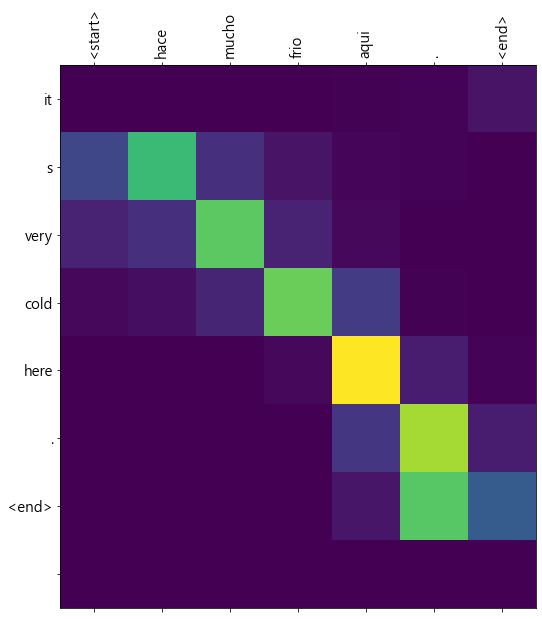

In [36]:
# 翻譯測試，並繪製熱力圖
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


<ipython-input-33-ce46f30c9852>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-33-ce46f30c9852>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


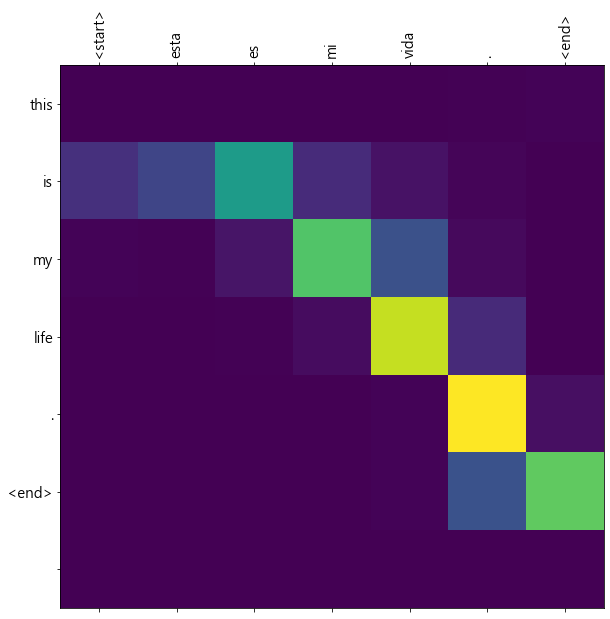

In [37]:
# 翻譯測試，並繪製熱力圖
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


<ipython-input-33-ce46f30c9852>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-33-ce46f30c9852>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


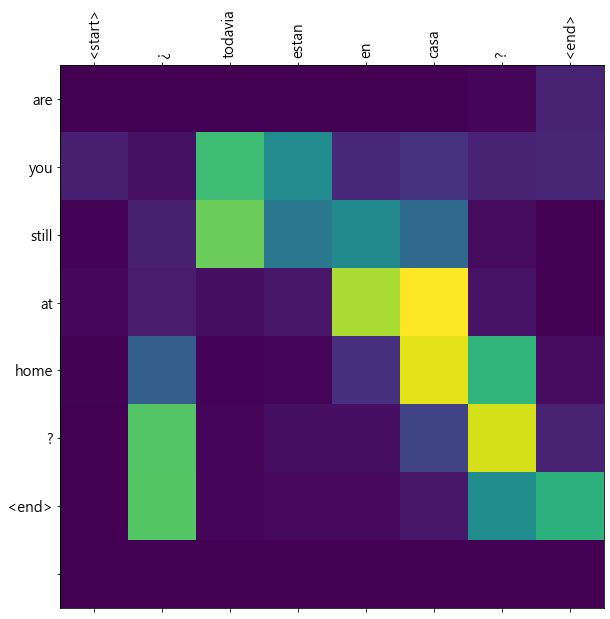

In [38]:
# 翻譯測試，並繪製熱力圖
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to find out . <end> 


<ipython-input-33-ce46f30c9852>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-33-ce46f30c9852>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


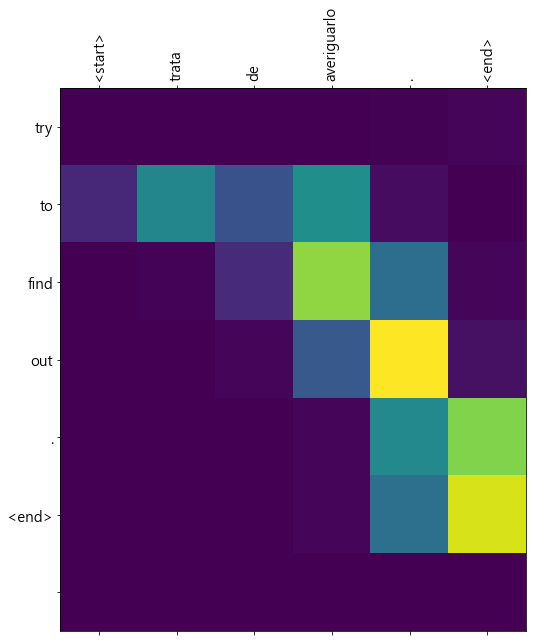

In [39]:
# wrong translation
translate(u'trata de averiguarlo.')

## 可下載其他語言試試看
* [Download a different dataset](http://www.manythings.org/anki/) 
